In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [16]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [17]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [18]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [19]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        #def init_weights(m):
        #    if type(m) == nn.Linear:
        #        if hasattr(m, 'weight') and m.weight is not None:
        #            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #            if m.bias is not None:
        #               init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        #self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [20]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=5000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    min_loss = float('inf')
    #prev_accuracy = 0
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate accuracy
        predicted_labels = torch.round(y_pred)
        correct_predictions = (predicted_labels == y_train).sum().item()
        total_samples = y_train.size(0)
        accuracy = correct_predictions / total_samples

        train_losses.append(train_loss.item())
        train_accuracies.append(accuracy)
        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'Accuracy: {accuracy:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} Accuracy: {test_accuracy:.4f} ', end='\r')

        # Check for convergence
        if train_loss.item() < min_loss and abs(train_loss.item()-min_loss)>1e-4:
            patience_counter = 0
            min_loss = train_loss.item()
        else:
            patience_counter += 1

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), accuracy, test_accuracy

In [21]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=5000,
                                         plot_curves=False, N = 3):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves,
                        num_epochs=num_epochs)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')
    return _, np.mean(train_losses), np.mean(test_losses), np.mean(train_accs), np.mean(test_accs)

In [22]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False, num_epochs=5000):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = train_with_different_initializations(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

# Monk 1

In [23]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

In [24]:
hidden_sizes = [5]
learning_rates = [0.01]
momentums = [0.9]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.9; batch size = 4; lambda = 0


Training - Epoch [371/5000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [371/5000], Loss: 0.0251 Accuracy: 0.9600 
 N. Epochs = 371 - Loss (train | test)= (0.0009189 | 0.02507) - Accuracy (train | test) = (1.0 | 0.96)
Training - Epoch [513/5000], Loss: 0.0107, Accuracy: 0.9899 | Test - Epoch [513/5000], Loss: 0.2656 Accuracy: 0.6400 
 N. Epochs = 513 - Loss (train | test)= (0.01071 | 0.2656) - Accuracy (train | test) = (0.98989898989899 | 0.64)
Training - Epoch [446/5000], Loss: 0.0013, Accuracy: 1.0000 | Test - Epoch [446/5000], Loss: 0.0865 Accuracy: 0.8800 
 N. Epochs = 446 - Loss (train | test)= (0.001331 | 0.08655) - Accuracy (train | test) = (1.0 | 0.88)
Train Loss: 0.004321 +- 0.004522
Test Loss: 0.1257 +- 0.102
Train Acc: 99.66 +- 0.4762 %
Test Acc: 82.67 +- 13.6 %
Training - Epoch [388/5000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [388/5000], Loss: 0.0255 Accuracy: 0.9600 
 N. Epochs = 388 - Loss (train | test)= (0.0009819 | 0.0255) - Accuracy (train | test) = (1.0 |

KeyboardInterrupt: 

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [25]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

Training - Epoch [396/5000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [396/5000], Loss: 0.0017 Accuracy: 1.0000 
 N. Epochs = 396 - Loss (train | test)= (0.001045 | 0.00165) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [263/5000], Loss: 0.0007, Accuracy: 1.0000 | Test - Epoch [263/5000], Loss: 0.0010 Accuracy: 1.0000 
 N. Epochs = 263 - Loss (train | test)= (0.0006619 | 0.0009815) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [369/5000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [369/5000], Loss: 0.0016 Accuracy: 1.0000 
 N. Epochs = 369 - Loss (train | test)= (0.001062 | 0.001649) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [350/5000], Loss: 0.0413, Accuracy: 0.9597 | Test - Epoch [350/5000], Loss: 0.0851 Accuracy: 0.9167 
 N. Epochs = 350 - Loss (train | test)= (0.04131 | 0.08509) - Accuracy (train | test) = (0.9596774193548387 | 0.9166666666666666)
Training - Epoch [308/5000], Loss: 0.0009, Accuracy: 1.0000 | Test - Epoch [308/5000], Loss

(308,
 0.008999186288565397,
 0.018372554914094508,
 0.9919354838709677,
 0.9833333333333332)

# Retrain the model to make final plots

Training - Epoch [273/5000], Loss: 0.0007, Accuracy: 1.0000 | Test - Epoch [273/5000], Loss: 0.0010 Accuracy: 1.0000 
 N. Epochs = 273 - Loss (train | test)= (0.0006541 | 0.0009708) - Accuracy (train | test) = (1.0 | 1.0)


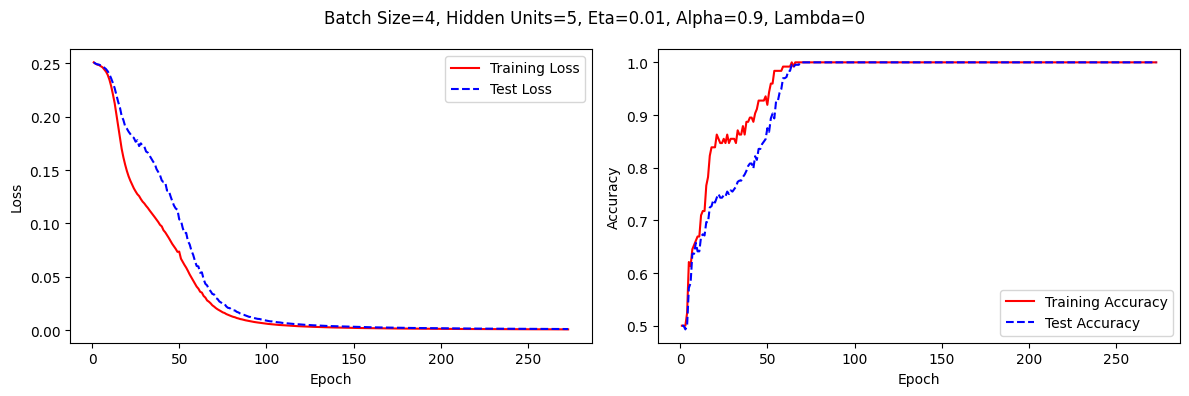

(273, 0.00065409648232162, 0.000970766763202846, 1.0, 1.0)

In [26]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [27]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [28]:
hidden_sizes = [4]
learning_rates = [0.05]
momentums = [0.8]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=4; lr=0.05; alpha = 0.8; batch size = 4; lambda = 0
Training - Epoch [142/5000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [142/5000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 142 - Loss (train | test)= (0.0003493 | 0.0004342) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [170/5000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [170/5000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 170 - Loss (train | test)= (0.0004695 | 0.0005166) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [163/5000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [163/5000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 163 - Loss (train | test)= (0.0004313 | 0.0006035) - Accuracy (train | test) = (1.0 | 1.0)
Train Loss: 0.0004167 +- 5.014e-05
Test Loss: 0.0005181 +- 6.913e-05
Train Acc: 100.0 +- 0.0 %
Test Acc: 100.0 +- 0.0 %
Training - Epoch [165/5000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [165/5000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 165 - Loss (train |

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

Training - Epoch [178/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [178/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 178 - Loss (train | test)= (0.000465 | 0.0004782) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [135/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [135/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 135 - Loss (train | test)= (0.0002801 | 0.0002974) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [131/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [131/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 131 - Loss (train | test)= (0.0002577 | 0.000277) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [181/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [181/1000], Loss: 0.0006 Accuracy: 1.0000 
 N. Epochs = 181 - Loss (train | test)= (0.0004784 | 0.0006498) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [124/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [124/1000], Loss: 0.0003 Accuracy: 1.00

Training - Epoch [143/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [143/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 143 - Loss (train | test)= (0.0004364 | 0.0004862) - Accuracy (train | test) = (1.0 | 1.0)


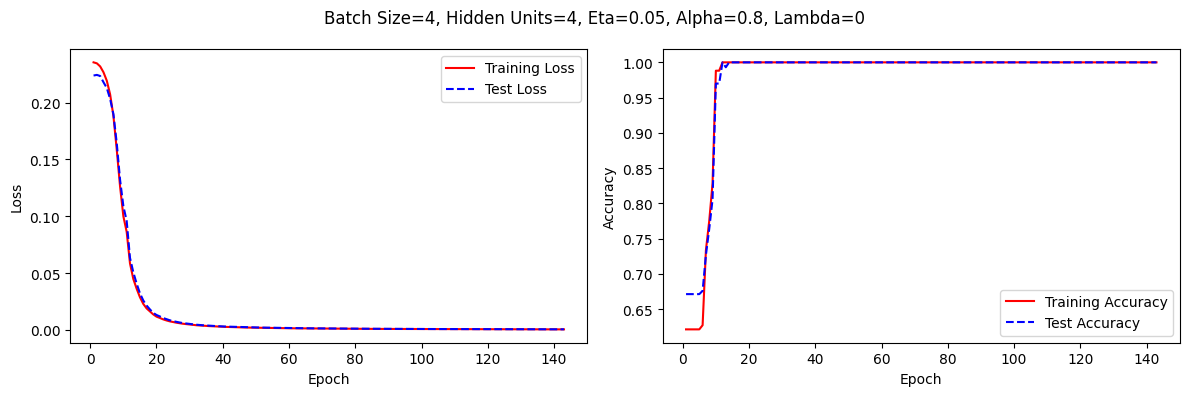

(143, 0.00043643367826007307, 0.00048622090253047645, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0
Training - Epoch [1894/5000], Loss: 0.0230, Accuracy: 0.9897 | Test - Epoch [1894/5000], Loss: 0.0071 Accuracy: 1.0000 
 N. Epochs = 1894 - Loss (train | test)= (0.02304 | 0.007102) - Accuracy (train | test) = (0.9896907216494846 | 1.0)
Training - Epoch [1029/5000], Loss: 0.0311, Accuracy: 0.9691 | Test - Epoch [1029/5000], Loss: 0.1299 Accuracy: 0.8400 
 N. Epochs = 1029 - Loss (train | test)= (0.03108 | 0.1299) - Accuracy (train | test) = (0.9690721649484536 | 0.84)
Training - Epoch [2952/5000], Loss: 0.0162, Accuracy: 0.9898 | Test - Epoch [2952/5000], Loss: 0.0414 Accuracy: 0.9583 
 N. Epochs = 2952 - Loss (train | test)= (0.01617 | 0.04143) - Accuracy (train | test) = (0.9897959183673469 | 0.9583333333333334)
Training - Epoch [2478/5000], Loss: 0.0066, Accuracy: 1.0000 | Test - Epoch [2478/5000], Loss: 0.1262 Accuracy: 0.8333 
 N. Epochs = 2478 - Loss (train | test)= (0.006552 | 0.1262) - Accuracy (train | test) = (

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               N=5)

Training - Epoch [1552/5000], Loss: 0.0403, Accuracy: 0.9590 | Test - Epoch [1552/5000], Loss: 0.0492 Accuracy: 0.9398 
 N. Epochs = 1552 - Loss (train | test)= (0.04034 | 0.04918) - Accuracy (train | test) = (0.9590163934426229 | 0.9398148148148148)
Training - Epoch [2763/5000], Loss: 0.0265, Accuracy: 0.9836 | Test - Epoch [2763/5000], Loss: 0.0503 Accuracy: 0.9352 
 N. Epochs = 2763 - Loss (train | test)= (0.02647 | 0.05032) - Accuracy (train | test) = (0.9836065573770492 | 0.9351851851851852)
Training - Epoch [1550/5000], Loss: 0.0376, Accuracy: 0.9590 | Test - Epoch [1550/5000], Loss: 0.0511 Accuracy: 0.9398 
 N. Epochs = 1550 - Loss (train | test)= (0.0376 | 0.05109) - Accuracy (train | test) = (0.9590163934426229 | 0.9398148148148148)
Training - Epoch [1813/5000], Loss: 0.0401, Accuracy: 0.9590 | Test - Epoch [1813/5000], Loss: 0.0505 Accuracy: 0.9398 
 N. Epochs = 1813 - Loss (train | test)= (0.04007 | 0.05053) - Accuracy (train | test) = (0.9590163934426229 | 0.939814814814814

Training - Epoch [1580/2000], Loss: 0.0378, Accuracy: 0.9590 | Test - Epoch [1580/2000], Loss: 0.0503 Accuracy: 0.9444 
 N. Epochs = 1580 - Loss (train | test)= (0.03776 | 0.05026) - Accuracy (train | test) = (0.9590163934426229 | 0.9444444444444444)


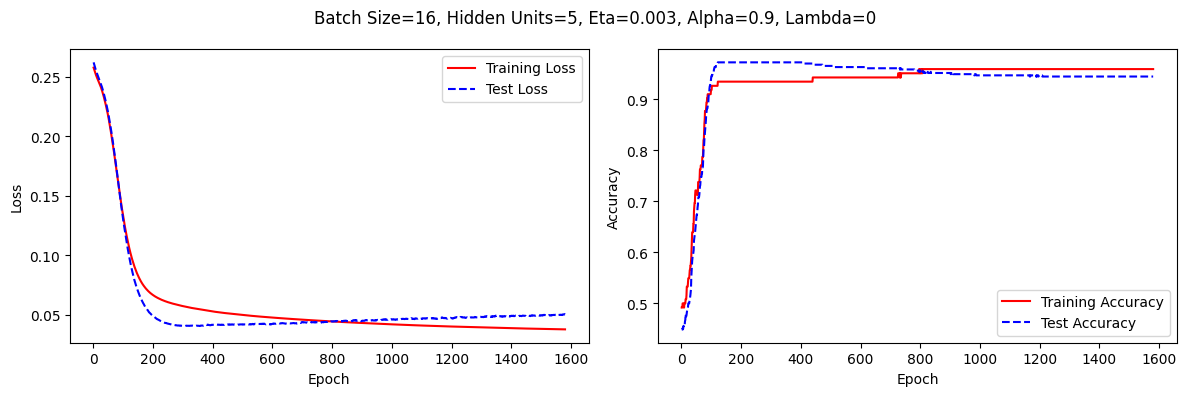

(1580,
 0.0377558097243309,
 0.050259824842214584,
 0.9590163934426229,
 0.9444444444444444)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=2000)

# Monk 3 (with regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.003]
momentums = [0.9]
batch_sizes = [16]
reg_coeffs = [0.005]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False,
                                    num_epochs=2000)

hidden_size=5; lr=0.003; alpha = 0.9; batch size = 16; lambda = 0.005
Training - Epoch [582/2000], Loss: 0.0665, Accuracy: 0.9278 | Test - Epoch [582/2000], Loss: 0.0296 Accuracy: 1.0000 
 N. Epochs = 582 - Loss (train | test)= (0.06653 | 0.0296) - Accuracy (train | test) = (0.9278350515463918 | 1.0)
Training - Epoch [617/2000], Loss: 0.0536, Accuracy: 0.9485 | Test - Epoch [617/2000], Loss: 0.1098 Accuracy: 0.8800 
 N. Epochs = 617 - Loss (train | test)= (0.05357 | 0.1098) - Accuracy (train | test) = (0.9484536082474226 | 0.88)
Training - Epoch [672/2000], Loss: 0.0676, Accuracy: 0.9286 | Test - Epoch [672/2000], Loss: 0.0503 Accuracy: 0.9583 
 N. Epochs = 672 - Loss (train | test)= (0.06765 | 0.05034) - Accuracy (train | test) = (0.9285714285714286 | 0.9583333333333334)
Training - Epoch [502/2000], Loss: 0.0461, Accuracy: 0.9490 | Test - Epoch [502/2000], Loss: 0.1272 Accuracy: 0.8750 
 N. Epochs = 502 - Loss (train | test)= (0.04614 | 0.1272) - Accuracy (train | test) = (0.948979591

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               num_epochs=5000,
               N=5)

Training - Epoch [581/5000], Loss: 0.0574, Accuracy: 0.9344 | Test - Epoch [581/5000], Loss: 0.0450 Accuracy: 0.9722 
 N. Epochs = 581 - Loss (train | test)= (0.05742 | 0.04503) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [1048/5000], Loss: 0.0502, Accuracy: 0.9344 | Test - Epoch [1048/5000], Loss: 0.0363 Accuracy: 0.9722 
 N. Epochs = 1048 - Loss (train | test)= (0.05024 | 0.03627) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [785/5000], Loss: 0.0533, Accuracy: 0.9344 | Test - Epoch [785/5000], Loss: 0.0408 Accuracy: 0.9722 
 N. Epochs = 785 - Loss (train | test)= (0.05327 | 0.04085) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [919/5000], Loss: 0.0525, Accuracy: 0.9344 | Test - Epoch [919/5000], Loss: 0.0405 Accuracy: 0.9722 
 N. Epochs = 919 - Loss (train | test)= (0.05249 | 0.04052) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Train

Training - Epoch [1008/5000], Loss: 0.0495, Accuracy: 0.9344 | Test - Epoch [1008/5000], Loss: 0.0372 Accuracy: 0.9699 
 N. Epochs = 1008 - Loss (train | test)= (0.04951 | 0.03723) - Accuracy (train | test) = (0.9344262295081968 | 0.9699074074074074)


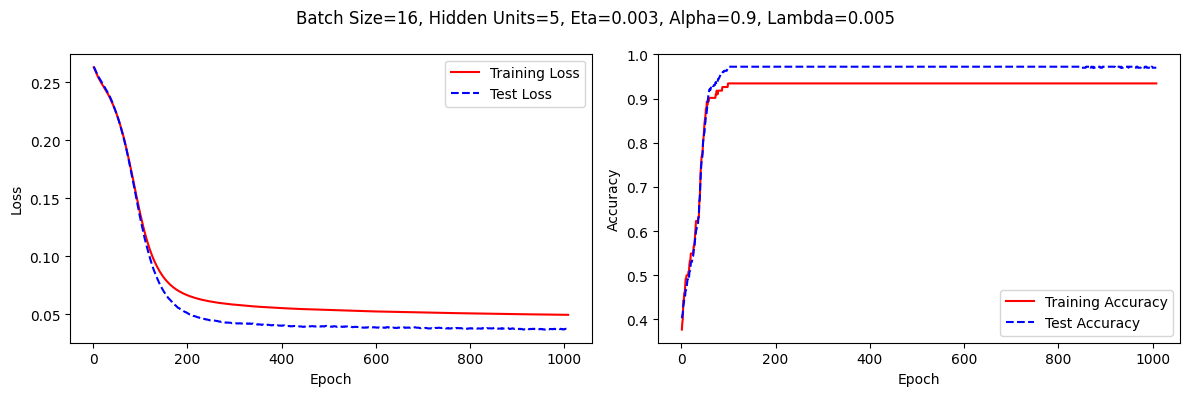

(1008,
 0.04950796067714691,
 0.03722917288541794,
 0.9344262295081968,
 0.9699074074074074)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=5000)